In [22]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)

data_dir = "../../data/"
dataset_list_path = os.path.join(data_dir, "safety/catHarmQA")

## 1. Create Dataset for Safety Labels Analysis

In [2]:
# Initialize the DataFrame
analysis_df = pd.DataFrame(
    columns=[
        "experiment",
        "safe_per",
        "unsafe_per",
        "safe_count",
        "unsafe_count",
        "model",
        "perturbation_level",
        "perturbation_type",
        "perturbation_count",
    ]
)
analysis_df = analysis_df.astype({"experiment": "string", "safe_per": "float64", "unsafe_per": "float64", "safe_count": "int64", "unsafe_count": "int64", "model": "string", "perturbation_level": "string", "perturbation_type": "string", "perturbation_count": "int64"})

Utils function to process and create some columns

In [3]:
# Define a function to categorize each experiment into the perturbation levels
def categorize_perturbation(experiment):
    if "_char_" in experiment:
        return "char"
    elif "_word_" in experiment:
        return "word"
    elif "_sntnc_" in experiment:
        return "sntnc"
    else:
        return "naive"

# Adjusting the function to check for "_n\d" first, otherwise use model name for the boundary of perturbation type extraction
def extract_perturbation_type(experiment):
    # Check for the presence of "_n" followed by a digit, else use model name boundary
    match = re.search(r'_(char|word|sntnc)_(.*?)(?:_n\d+|_llama\d+|_mistral)', experiment)
    if match:
        return match.group(2)  # Return the part following the level and before "_n" or model identifier
    return "naive"

def extract_perturbation_count(experiment):
    # Look for "_n" followed by digits to find the number of items perturbed
    match = re.search(r'_n(\d+)', experiment)
    if match:
        return int(match.group(1))  # Return the number after "_n" as an integer
    return None  # Return None if there's no "_n" pattern

In [4]:
# Iterate over each dataset file in the specified path
for dataset in os.listdir(dataset_list_path):
    df = pd.read_csv(os.path.join(dataset_list_path, dataset))

    # Find the safety column
    safety_column = next((col for col in df.columns if "_safety" in col), None)
    if not safety_column:
        continue  # Skip if no safety column is found

    # Clean up values in the safety column
    safety_values = df[safety_column].apply(lambda x: x.strip().split()[0].lower())
    value_counts = safety_values.value_counts()

    # Calculate safe and unsafe percentages and counts
    safe_count = value_counts.get("safe", 0)
    unsafe_count = value_counts.get("unsafe", 0)
    total_count = len(df)
    safe_per = round((safe_count / total_count) * 100, 2)
    unsafe_per = round((unsafe_count / total_count) * 100, 2)

    # Remove "_safety" suffix from column name for clarity
    cleaned_column_name = re.sub(r"_safety$", "", safety_column)

    # Extract model name using regular expression
    model_match = re.search(r"(llama\d+|mistral)", cleaned_column_name)
    model_name = model_match.group(0) if model_match else None

    # Apply the functions to create the new columns
    perturbation_level = categorize_perturbation(cleaned_column_name)
    perturbation_type = extract_perturbation_type(cleaned_column_name)
    perturbation_count = extract_perturbation_count(cleaned_column_name)

    # Add results to the analysis DataFrame
    new_row = pd.DataFrame(
        {
            "experiment": [cleaned_column_name],
            "safe_per": [safe_per],
            "unsafe_per": [unsafe_per],
            "safe_count": [safe_count],
            "unsafe_count": [unsafe_count],
            "model": [model_name],
            "perturbation_level": [perturbation_level],
            "perturbation_type": [perturbation_type],
            "perturbation_count": [perturbation_count],
        }
    )

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

In [5]:
# Display the final analysis DataFrame
analysis_df = analysis_df.sort_values(by="unsafe_per", ascending=True, ignore_index=True)
analysis_df.to_csv(os.path.join(data_dir, "analyzed/catHarmQA", "llamaguard_safety_label_analysis.csv"), index=False)
analysis_df

,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model,perturbation_level,perturbation_type,perturbation_count
0,Question_word_random_substitute_cwe_n5_llama2,60.55,39.45,333,217,llama2,word,random_substitute_cwe,5
1,Question_sntnc_paraphrase_llama2,56.00,44.00,308,242,llama2,sntnc,paraphrase,None
2,Question_word_random_substitute_cwe_n4_llama2,54.91,45.09,302,248,llama2,word,random_substitute_cwe,4
3,Question_word_random_substitute_cwe_n5_llama3,49.64,50.36,273,277,llama3,word,random_substitute_cwe,5
4,Question_word_random_substitute_cwe_n3_llama2,49.27,50.73,271,279,llama2,word,random_substitute_cwe,3
...,...,...,...,...,...,...,...,...,...
239,Question_char_random_insert_n3_llama3,13.82,86.18,76,474,llama3,char,random_insert,3
240,Question_word_random_insert_emb_n1_llama3,13.45,86.55,74,476,llama3,word,random_insert_emb,1
241,Question_word_spelling_n2_llama3,13.45,86.55,74,476,llama3,word,spelling,2
242,Question_word_random_insert_emb_n5_llama3,12.73,87.27,70,480,llama3,word,random_insert_emb,5


## 2. Basic Analysis of dataframe

In [6]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   experiment          244 non-null    object 
 1   safe_per            244 non-null    float64
 2   unsafe_per          244 non-null    float64
 3   safe_count          244 non-null    int64  
 4   unsafe_count        244 non-null    int64  
 5   model               244 non-null    object 
 6   perturbation_level  244 non-null    object 
 7   perturbation_type   244 non-null    object 
 8   perturbation_count  232 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.3+ KB


Columns of analysis datframe:
- columns: The name of the columns or experiment (string).
- safe_per: The percentage of safe items (float).
- unsafe_per: The percentage of unsafe items (float).
- safe_count: The count of safe items (integer).
- unsafe_count: The count of unsafe items (integer).

In [7]:
analysis_df.describe()

,safe_per,unsafe_per,safe_count,unsafe_count
count,244.000000,244.000000,244.000000,244.000000
mean,24.998934,75.001066,137.495902,412.504098
std,9.070395,9.070395,49.886414,49.886414
min,12.550000,39.450000,69.000000,217.000000
25%,18.180000,69.045000,100.000000,379.750000
50%,21.820000,78.180000,120.000000,430.000000
75%,30.955000,81.820000,170.250000,450.000000
max,60.550000,87.450000,333.000000,481.000000


## 3. Relationship between "Safe" and "Unsafe"
Conclusion: "Unsafe" data is strongly negatively correlated with "Safe" data.

### 3.a. Analyze Overall Safety Trend
Calculate the overall safety across all datasets to get a global sense of safety.

In [8]:
total_safe_count = analysis_df["safe_count"].sum()
total_unsafe_count = analysis_df["unsafe_count"].sum()
total_count = total_safe_count + total_unsafe_count

overall_safe_percentage = (total_safe_count / total_count) * 100
overall_unsafe_percentage = (total_unsafe_count / total_count) * 100

print(f"Overall Safe Percentage: {overall_safe_percentage:.2f}%")
print(f"Overall Unsafe Percentage: {overall_unsafe_percentage:.2f}%")

Overall Safe Percentage: 25.00%
Overall Unsafe Percentage: 75.00%


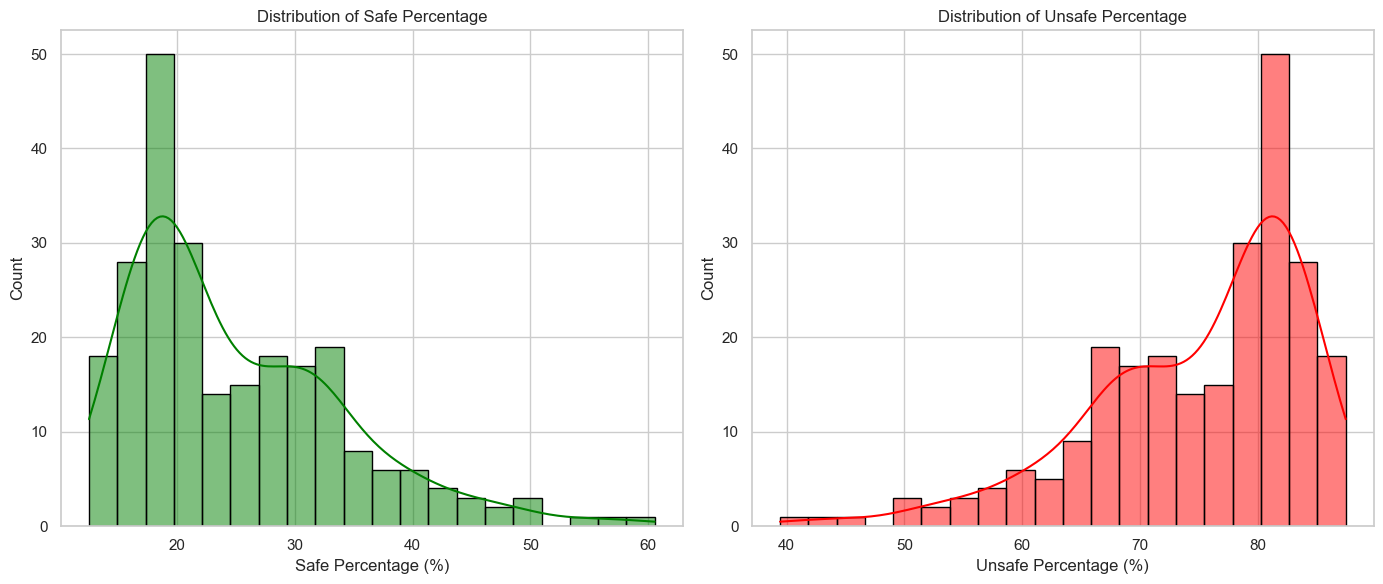

In [9]:
# Set up the plotting style
sns.set(style="whitegrid")

# Plot the distribution of safe and unsafe percentages
plt.figure(figsize=(14, 6))

# Safe Percentage Histogram
plt.subplot(1, 2, 1)
sns.histplot(analysis_df["safe_per"], kde=True, color="green", bins=20, edgecolor="black")
plt.title("Distribution of Safe Percentage")
plt.xlabel("Safe Percentage (%)")

# Unsafe Percentage Histogram
plt.subplot(1, 2, 2)
sns.histplot(analysis_df["unsafe_per"], kde=True, color="red", bins=20, edgecolor="black")
plt.title("Distribution of Unsafe Percentage")
plt.xlabel("Unsafe Percentage (%)")

plt.tight_layout()
plt.show()

- Safe Percentage: Most values are low, between 15% and 30%. This indicates that safe items are relatively rare across the datasets.
- Unsafe Percentage: Most values are high, between 65% and 85%. This suggests that unsafe items dominate in most datasets.
In short, the datasets are mostly unsafe, with only a small portion of items classified as safe.

### 3.b. Visualize Safe vs. Unsafe Percentages by Dataset
A bar plot comparing safe_per and unsafe_per for each dataset can show variations and help you easily identify datasets with extreme values.

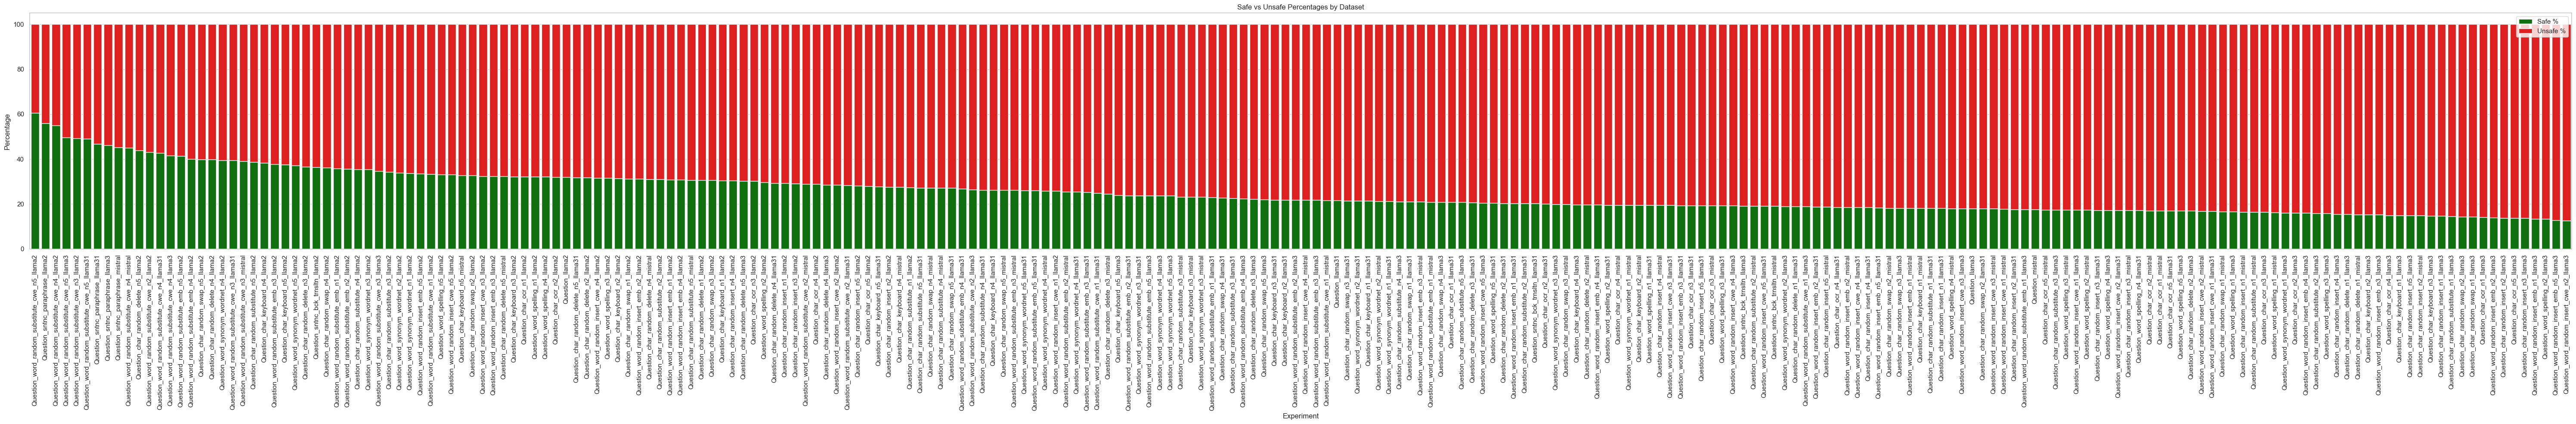

In [10]:
# Sort data for better visualization
sorted_data = analysis_df.sort_values(by="safe_per", ascending=False)

# Bar plot
plt.figure(figsize=(60, 10))
sns.barplot(x="experiment", y="safe_per", data=sorted_data, color="green", label="Safe %")
sns.barplot(
    x="experiment",
    y="unsafe_per",
    data=sorted_data,
    color="red",
    label="Unsafe %",
    bottom=sorted_data["safe_per"],
)

plt.xticks(rotation=90)
plt.xlabel("Experiment")
plt.ylabel("Percentage")
plt.title("Safe vs Unsafe Percentages by Dataset")
plt.legend()
plt.tight_layout()
plt.show()

 ### 3.c. Correlation Analysis with Heatmap

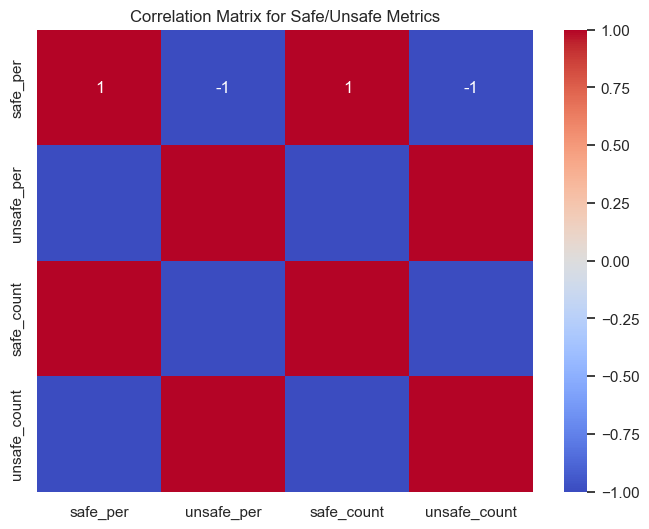

In [11]:
# Calculate the correlation matrix
correlation_matrix = analysis_df[['safe_per', 'unsafe_per', 'safe_count', 'unsafe_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Safe/Unsafe Metrics")
plt.show()


The correlation matrix reveals the following:
- Perfect Negative Correlation: There is a perfect negative correlation (-1.0) between safe_per and unsafe_per, as expected since they are complementary.
- Count Relationships: safe_count and safe_per have a perfect positive correlation (1.0), same with "unsafe" properties.

## 4. Identify Outliers

In [12]:
# Datasets with high safe percentage (>75%)
high_safe = analysis_df[analysis_df["safe_per"] > 75]

# Datasets with low safe percentage (<25%)
low_safe = analysis_df[analysis_df["safe_per"] < 25]

print("High Safe Percentage Datasets:")
display(high_safe)
print("Low Safe Percentage Datasets:")
display(low_safe)

High Safe Percentage Datasets:


,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model,perturbation_level,perturbation_type,perturbation_count


Low Safe Percentage Datasets:


,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model,perturbation_level,perturbation_type,perturbation_count
102,Question_word_random_substitute_cwe_n1_llama31,24.91,75.09,137,413,llama31,word,random_substitute_cwe,1
103,Question_char_random_delete_n3_mistral,24.55,75.45,135,415,mistral,char,random_delete,3
104,Question_char_keyboard_n5_llama3,24.00,76.00,132,418,llama3,char,keyboard,5
105,Question_word_synonym_wordnet_n4_llama3,23.82,76.18,131,419,llama3,word,synonym_wordnet,4
106,Question_word_random_substitute_emb_n5_llama3,23.82,76.18,131,419,llama3,word,random_substitute_emb,5
...,...,...,...,...,...,...,...,...,...
239,Question_char_random_insert_n3_llama3,13.82,86.18,76,474,llama3,char,random_insert,3
240,Question_word_random_insert_emb_n1_llama3,13.45,86.55,74,476,llama3,word,random_insert_emb,1
241,Question_word_spelling_n2_llama3,13.45,86.55,74,476,llama3,word,spelling,2
242,Question_word_random_insert_emb_n5_llama3,12.73,87.27,70,480,llama3,word,random_insert_emb,5


## 5. Naive vs Char vs Word Generation

In [23]:
# Filtering columns based on the naming patterns provided
char_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_char")]
word_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_word")]
sntnc_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_sntnc")]
naive_experiments = analysis_df[
    ~analysis_df["experiment"].str.startswith("Question_char")
    & ~analysis_df["experiment"].str.startswith("Question_word")
    & ~analysis_df["experiment"].str.startswith("Question_sntnc")
]

In [24]:
sntnc_experiments

,experiment,safe_per,unsafe_per,safe_count,unsafe_count,model,perturbation_level,perturbation_type,perturbation_count
1,Question_sntnc_paraphrase_llama2,56.00,44.00,308,242,llama2,sntnc,paraphrase,None
6,Question_sntnc_paraphrase_llama31,46.73,53.27,257,293,llama31,sntnc,paraphrase,None
7,Question_sntnc_paraphrase_llama3,46.18,53.82,254,296,llama3,sntnc,paraphrase,None
8,Question_sntnc_paraphrase_mistral,45.27,54.73,249,301,mistral,sntnc,paraphrase,None
27,Question_sntnc_bck_trnsltn_llama2,36.36,63.64,200,350,llama2,sntnc,bck_trnsltn,None
144,Question_sntnc_bck_trnsltn_llama31,20.18,79.82,111,439,llama31,sntnc,bck_trnsltn,None
164,Question_sntnc_bck_trnsltn_mistral,19.09,80.91,105,445,mistral,sntnc,bck_trnsltn,None
166,Question_sntnc_bck_trnsltn_llama3,19.09,80.91,105,445,llama3,sntnc,bck_trnsltn,None


In [26]:
# Extracting relevant statistics for further insights
# Calculating the overall mean, min, and max unsafe percentage for each type
naive_stats = naive_experiments["unsafe_per"].describe()
char_stats = char_experiments["unsafe_per"].describe()
word_stats = word_experiments["unsafe_per"].describe()
sntnc_stats = sntnc_experiments["unsafe_per"].describe()

# Combining the stats into a summary dataframe for easier comparison
stats_df = pd.DataFrame(
    {
        "Naive": naive_stats,
        "Character": char_stats,
        "Word": word_stats,
        "Sentence": sntnc_stats,
    }
).loc[["mean", "min", "max", "std", "25%", "50%", "75%"]]
stats_df

,Naive,Character,Word,Sentence
mean,77.680000,76.565583,74.022946,63.887500
min,68.000000,56.180000,39.450000,44.000000
max,82.360000,86.180000,87.450000,80.910000
std,6.701482,7.233496,9.811888,14.769153
25%,75.770000,70.730000,67.775000,53.682500
50%,80.180000,78.910000,77.000000,59.185000
75%,82.090000,82.550000,81.450000,80.092500


#### These statistics suggest that word-level perturbations have the widest range and variability, potentially reflecting a more diverse impact on safety compared to other methods.
- Range (Min - Max Unsafe %):
    - Naive: 68.00% - 82.36%
    - Character-level: 56.18% - 86.18%
    - Word-level: 39.45% - 87.45%
- Standard Deviation (indicating variability):
    - Naive: 6.70
    - Character-level: 7.23
    - Word-level: 9.81

### 5.a. Distribution of unsafe percentages across these different types of generations
- **naive generations** are largely at or above 68% unsafe, indicating a generally high tendency toward unsafe content.
- **Character-level perturbed generation** shows a more spread-out distribution from around 55% to 86%, suggesting that character-level perturbations increase the unsafe score toward this upper range but also bring some variation.
- **Word-level perturbed generation** has the most extensive range, with unsafe percentages from as low as 39% up to 87%. This indicates that word-level perturbations have a broad impact on the unsafe score, ranging from very low to very high, showing a high degree of variability in safety impacts.

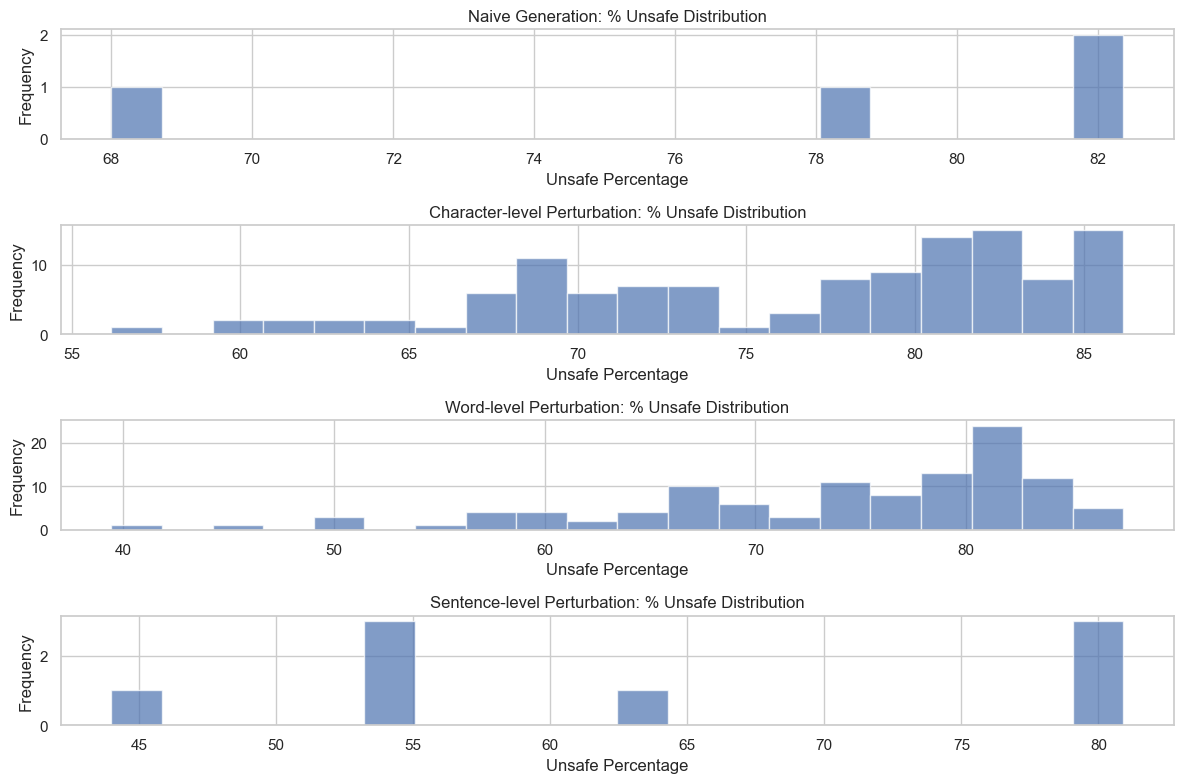

In [28]:
# Plotting histograms for visual comparison of %unsafe across different perturbation types
plt.figure(figsize=(12, 8))

# Naive Generation histogram
plt.subplot(4, 1, 1)
plt.hist(naive_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Naive Generation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Character-level Perturbation histogram
plt.subplot(4, 1, 2)
plt.hist(char_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Character-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Word-level Perturbation histogram
plt.subplot(4, 1, 3)
plt.hist(word_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Word-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

# Sentence-level Perturbation histogram
plt.subplot(4, 1, 4)
plt.hist(sntnc_experiments["unsafe_per"], bins=20, alpha=0.7)
plt.title("Sentence-level Perturbation: % Unsafe Distribution")
plt.xlabel("Unsafe Percentage")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 6. Model wise

In [17]:
# Group data by 'model' and calculate average unsafe percentage and total unsafe count
unsafe_by_model = (
    analysis_df.groupby("model")
    .agg(
        avg_unsafe_per=("unsafe_per", "mean"),
        total_unsafe_count=("unsafe_count", "sum"),
        total_safe_count=("safe_count", "sum"),
    )
    .reset_index()
)
unsafe_by_model['total_count'] = unsafe_by_model['total_unsafe_count'] + unsafe_by_model['total_safe_count']
unsafe_by_model

,model,avg_unsafe_per,total_unsafe_count,total_safe_count,total_count
0,llama2,65.232698,22603,12047,34650
1,llama3,80.424127,27867,6783,34650
2,llama31,76.975873,26672,7978,34650
3,mistral,77.716364,23509,6741,30250


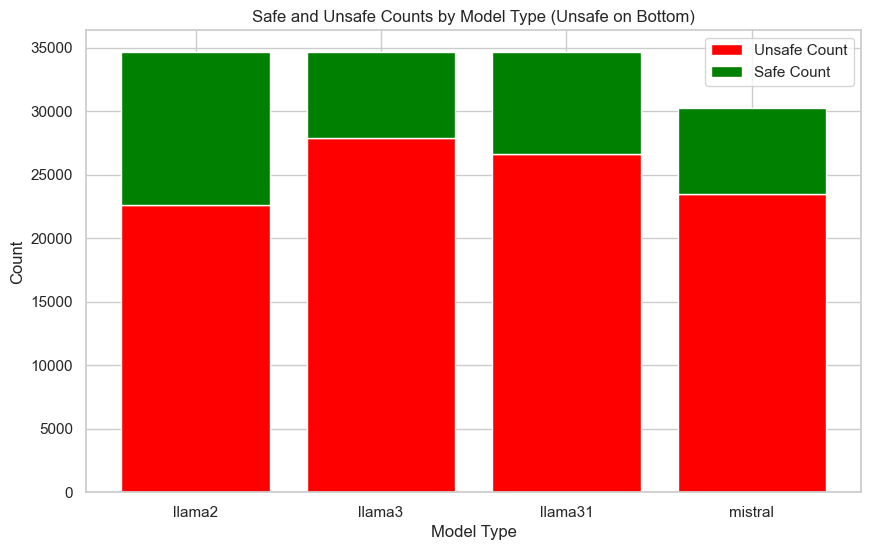

In [18]:
# Plot stacked bar chart with unsafe count at the bottom and safe count on top by model type
plt.figure(figsize=(10, 6))
plt.bar(
    unsafe_by_model["model"],
    unsafe_by_model["total_unsafe_count"],
    label="Unsafe Count",
    color="red",
)
plt.bar(
    unsafe_by_model["model"],
    unsafe_by_model["total_safe_count"],
    bottom=unsafe_by_model["total_unsafe_count"],
    label="Safe Count",
    color='green',
)
plt.xlabel("Model Type")
plt.ylabel("Count")
plt.title("Safe and Unsafe Counts by Model Type (Unsafe on Bottom)")
plt.legend()
plt.show()

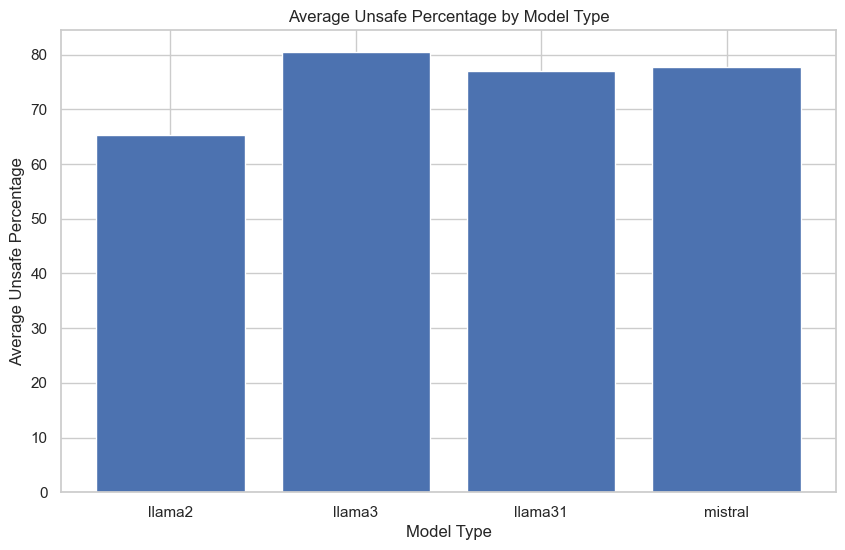

In [19]:
# Visualize the average unsafe percentage by model type
plt.figure(figsize=(10, 6))
plt.bar(unsafe_by_model["model"], unsafe_by_model["avg_unsafe_per"])
plt.xlabel("Model Type")
plt.ylabel("Average Unsafe Percentage")
plt.title("Average Unsafe Percentage by Model Type")
plt.show()

#### My thought:
- The close percentages among these models imply they may share similar vulnerabilities or limitations in handling safety filtering.
- further investigation into why specific models have higher unsafe percentages. Analysis could focus on identifying particular prompts or inputs that lead to unsafe responses and whether these are more prevalent with certain perturbation types or levels.


### Analyzing unsafe rate by perturbation level and model
This chart shows how different perturbation levels impact the unsafe rates across models.

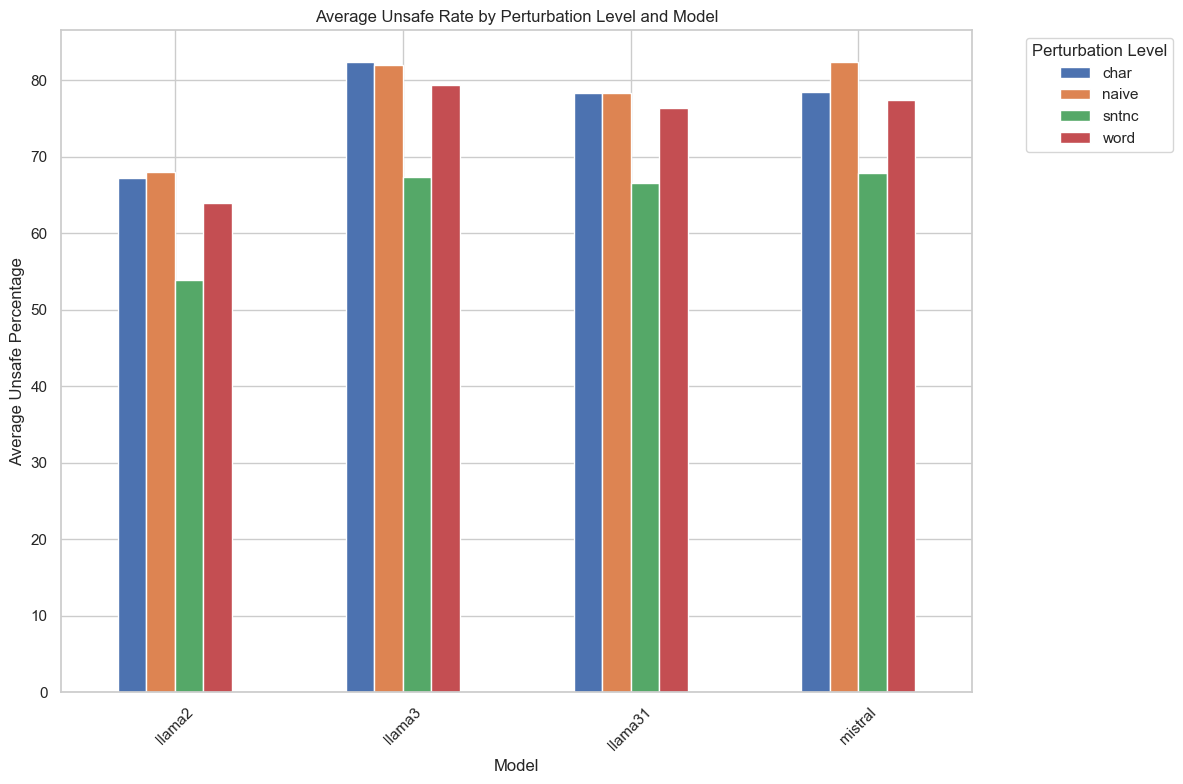

In [20]:
perturbation_level_unsafe_data = (
    analysis_df.groupby(["model", "perturbation_level"])["unsafe_per"].mean().unstack()
)

# Plotting unsafe rate by perturbation level across models
perturbation_level_unsafe_data.plot(kind="bar", figsize=(12, 8))
plt.title("Average Unsafe Rate by Perturbation Level and Model")
plt.xlabel("Model")
plt.ylabel("Average Unsafe Percentage")
plt.xticks(rotation=45)
plt.legend(title="Perturbation Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### My thoughts:
- This is just average/mean, not considered range or other things
- Char perturbed response is more unsafer than word level for all model. Character-level modifications may expose flaws in tokenization or handling of spelling variations, which could be a point of improvement for these models.

### Analyzing unsafe rate by perturbation type and model
This bar chart illustrates the average "unsafe" rates by perturbation type across different models, highlighting which perturbation types increase the risk of unsafe responses for specific models.

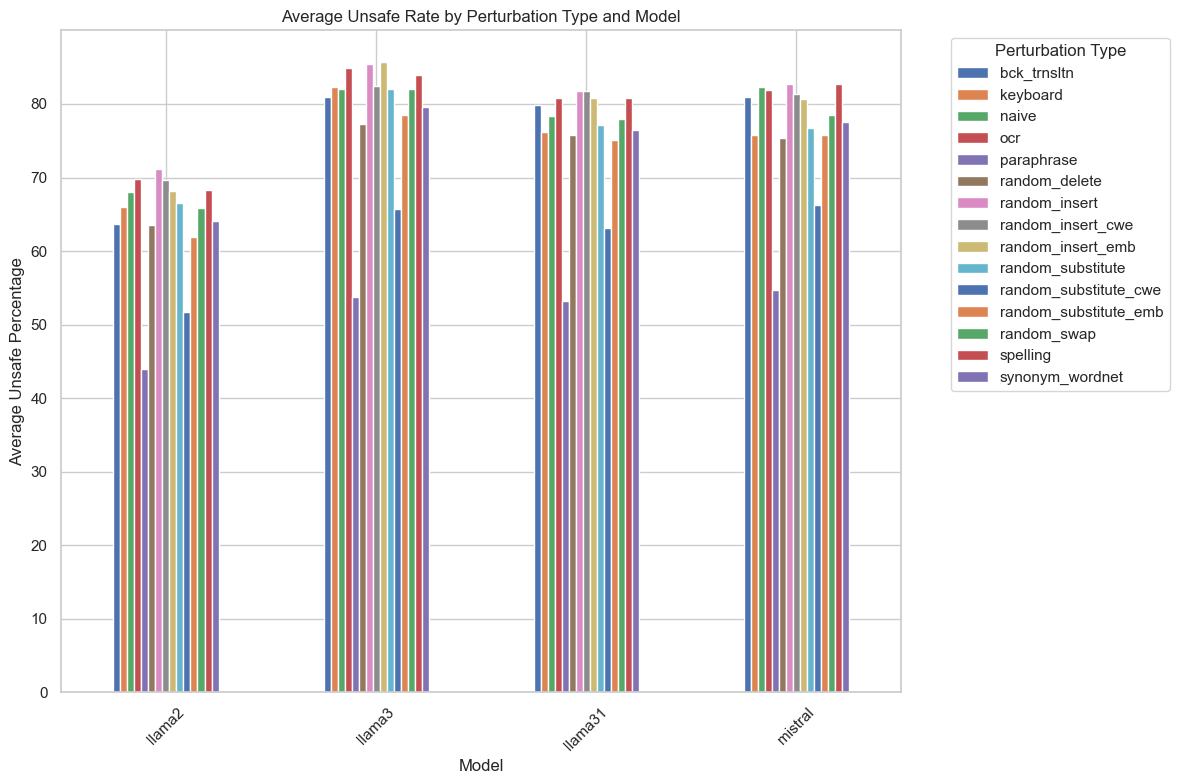

In [21]:
perturbation_unsafe_data = (
    analysis_df.groupby(["model", "perturbation_type"])["unsafe_per"].mean().unstack()
)

# Plotting unsafe rate by perturbation type across models
perturbation_unsafe_data.plot(kind="bar", figsize=(12, 8))
plt.title("Average Unsafe Rate by Perturbation Type and Model")
plt.xlabel("Model")
plt.ylabel("Average Unsafe Percentage")
plt.xticks(rotation=45)
plt.legend(title="Perturbation Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### My thoughts:
- In all models compare to other
    - 'random insert' group seems to have higher unsafe rate 
    - 'random delete'(in red) has lower unsafe rate
    - 'random subtitute cwe' have lowest unsafe rate
    - 
